# <font color="#8333ff">Projet 5 (PARTIE 3): Segmentez des clients d'un site e-commerce

# <font color="#8333ff">Simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.

Une fois le modèle de segmentation choisi, nous devons faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance.

Ainsi, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

# <font color="#8333ff"> Partie 3: Simulation </font>

## <font color="blue">Sommaire</font>

1. [Import de la dataframe](#section_1)        
2. [Stabilité temporelle de la segmentation](#section_2) </br>
    a.[Période totale à couvrir](#section_2_a)</br>
    b.[Iteration du K-means avec des deltas](#section_2_b)</br>
    c.[Score ARI](#section_2_b)</br>

On importe les librairies nécessaires pour ces analyses ainsi que la base cleanée.


In [1]:
#import des librairies dont nous aurons besoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## <font color="red" id="section_1">1. Import de la dataframe </font>

In [67]:
#import du ficher csv prêt pour la modélisation 'data_clustering.csv' et chargement en une dataframe "data_clustering"
data_clustering = pd.read_csv('data_clustering.csv')


## <font color="red" id="section_2">2. Délai de maintenance du modèle choisi </font>

### <font color="blue" id="section_8_a"> a. Période concernée </font>

In [3]:
#Calcul de la période totale en mois
#1 mois fait 30.417 jours en moyenne
time_total = int((data_clustering["recency"].max() - data_clustering["recency"].min())/30.471)

print("La période complète des commandes est de {} mois.".format(time_total))

La période complète des commandes est de 23 mois.


In [49]:
nb_clients = data_clustering.customer_unique_id.unique().shape[0]
print("Le nombre de clients est de : {} ".format(nb_clients))

Le nombre de clients est de : 93396 


Regardons la répartition des clients selon le temps. 

In [68]:
data_clustering.head()

,Unnamed: 0,customer_unique_id,recency,frequency,monetary,customer_id,customer_city,customer_state,order_id,order_status,...,payment_sequential,payment_type,payment_installments,payment_value,shipping_limit_date,product_id,price,freight_value,product_category_name_english,order_time_delivered
0,0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,fadbb3709178fc513abc1b2670aa1ad2,cajamar,SP,e22acc9c116caa3f2b7121bbb380d08e,delivered,...,1,credit_card,8,141.90,2018-05-15 11:11:18,372645c7439f9661fbbacfd129aa92ec,129.90,12.00,home,4.0
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4cb282e167ae9234755102258dd52ee8,osasco,SP,3594e05a005ac4d06a72673270ef9ec9,delivered,...,1,credit_card,1,27.19,2018-05-11 17:56:33,5099f7000472b634fea8304448d20825,18.90,8.29,health_beauty,4.0
2,2,0000f46a3911fa3c0805444483337064,542,1,69.00,9b3932a6253894a02c1df9d19004239f,sao jose,SC,b33ec3b699337181488304f362a6b734,delivered,...,1,credit_card,8,86.22,2017-03-15 21:05:03,64b488de448a5324c4134ea39c28a34b,69.00,17.22,office_stationery_books,1.0
3,3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,914991f0c02ef0843c0e7010c819d642,belem,PA,41272756ecddd9a9ed0180413cc22fb6,delivered,...,1,credit_card,4,43.62,2017-10-18 21:49:17,2345a354a6f2033609bbf62bf5be9ef6,25.99,17.63,technology,11.0
4,4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,47227568b10f5f58a524a75507e6992c,sorocaba,SP,d957021f1127559cd947b62533f484f7,delivered,...,1,credit_card,6,196.89,2017-11-22 20:06:52,c72e18b3fe2739b8d24ebf3102450f37,180.00,16.89,technology,7.0


In [4]:
data_clustering['order_purchase_timestamp'].min()

'2016-09-04 21:15:19'

In [5]:
data_clustering['order_purchase_timestamp'].max()

'2018-09-03 09:06:57'

La période des commandes va de début septembre 2016 à début Septembre 2018.

### <font color="blue" id="section_8_b"> b. Iteration du K-means et calcul du score ARI </font>

Déterminons d'abord le nombre de jours écoulé à partir de la variable "recency".

In [6]:
print("La date d'achat la plus récente 2018-09-03 correspond à un nombre de jours écoulé = {} jours et la date d'achat la plus ancienne 2016-09-04 correspond à un nombre de jours écoulé = {} jours.".format(data_clustering.recency.min(),data_clustering.recency.max()))

La date d'achat la plus récente 2018-09-03 correspond à un nombre de jours écoulé = 0 jours et la date d'achat la plus ancienne 2016-09-04 correspond à un nombre de jours écoulé = 729 jours.


Lançons le Kmeans sur notre sélection de variables en choisissant 4 clusters.

In [7]:
var=['recency', 'frequency', 'monetary']
X = data_clustering[var]

In [8]:
from sklearn.preprocessing import StandardScaler

Je vais créer un premier fichier initial de clients sans les derniers 70 jours:

In [9]:
from sklearn.cluster import KMeans
from sklearn import cluster

#On filtre sans les 70 derniers jours
F0 = X[X['recency']>=70]
#On doit standardiser les données
sc_F0=StandardScaler()
F0_scaled=sc_F0.fit_transform(F0)


# Clustering avec le KMeans en utilisante le meilleur nombre de clusters
model = KMeans(n_clusters=4, random_state=0) 
model_F0 = model.fit(F0_scaled)

Créons maintenant un fichier F1 dans lequel nous retrouverons les clients qui ont achetés dans les 10 jours suivants:


In [10]:
#On filtre sans les 70 derniers jours et les 10 jours d'avant
F1 = X[X['recency']>=60]
#On doit standardiser les données
sc_F1=StandardScaler()
F1_scaled=sc_F1.fit_transform(F1)

model = KMeans(n_clusters=4,  random_state=0) 
model_F1 = model.fit(F1_scaled)

# Le clustering de F1 est prédit en utilisant le modèle F0  
F1_pred = model_F0.predict(sc_F0.transform(F1)) 

Le score ARI nous permet de voir s'il existe une similarité entre les clusters prédits et vrais.
Un score proche de 0 est donné pour un étiquetage aléatoire et 1 lorsque les clusterings sont identiques.

In [11]:
from sklearn.metrics.cluster import adjusted_rand_score

rand_0 = adjusted_rand_score(model_F1.labels_, F1_pred)
# Le score ARI calcule la similarité entre les clusters prédits et les vrais clusters apres 10 jours
rand_0 

0.9843929567555147

Créons un fichier F2 en y mettant les clients qui ont achetés dans les 10 jours suivants:


In [12]:
F2 = X[X['recency']>=50]
sc_F2=StandardScaler()
F2_scaled=sc_F2.fit_transform(F2)

model = KMeans(n_clusters=4, random_state=0) 
model_F2 = model.fit(F2_scaled)

F2_pred = model_F0.predict(sc_F0.transform(F2))

In [13]:
# Le score ARI calcule la similarité entre les clusters prédits et les vrais clusters apres 20 jours
rand_1 = adjusted_rand_score(model_F2.labels_, F2_pred)

rand_1 

0.9671474878816277

Nous allons créer un nouveau groupe F3 en incluant les clients qui ont achetés dans les 10 jours suivants :

In [14]:
F3 = X[X['recency']>=40]
sc_F3=StandardScaler()
F3_scaled=sc_F3.fit_transform(F3)

model = KMeans(n_clusters=4, random_state=0) 
model_F3 = model.fit(F3_scaled)

F3_pred = model_F0.predict(sc_F0.transform(F3))

In [15]:
 # Le score ARI calcule la similarité entre les clusters prédits et les vrais clusters apres 30 jours 
rand_2 = adjusted_rand_score(model_F3.labels_, F3_pred)

rand_2

0.9417470361854026

Continuons à faire des simulations en augmentant de 10 jours à chaque fois.

In [16]:
F4 = X[X['recency']>=30]
sc_F4=StandardScaler()
F4_scaled=sc_F4.fit_transform(F4)

model = KMeans(n_clusters=4, random_state=0) 
model_F4 = model.fit(F4_scaled)

F4_pred = model_F0.predict(sc_F0.transform(F4))

In [17]:
 # Le score ARI calcule la similarité entre les clusters prédits et les vrais clusters apres 40 jours 
rand_3 = adjusted_rand_score(model_F4.labels_, F4_pred)
rand_3 

0.9112373075402385

In [18]:
F5 = X[X['recency']>=20]
sc_F5=StandardScaler()
F5_scaled=sc_F5.fit_transform(F5)

model = KMeans(n_clusters=4, random_state=0) 
model_F5 = model.fit(F5_scaled)

F5_pred = model_F0.predict(sc_F0.transform(F5))

In [19]:
 # Le score ARI calcule la similarité entre les clusters prédits et les vrais clusters apres 50 jours
rand_4 = adjusted_rand_score(model_F5.labels_, F5_pred)
rand_4

0.6743062700072663

In [20]:
F6 = X[X['recency']>=10]
sc_F6=StandardScaler()
F6_scaled=sc_F6.fit_transform(F6)

model = KMeans(n_clusters=4, random_state=0) 
model_F6 = model.fit(F6_scaled)

F6_pred = model_F0.predict(sc_F0.transform(F6))

In [21]:
 # Le score ARI calcule la similarité entre les clusters prédits et les vrais clusters apres 60 jours
rand_5 = adjusted_rand_score(model_F6.labels_, F6_pred)
rand_5

0.6593599585129973

In [63]:
F7 = X[X['recency']>=0]
sc_F7=StandardScaler()
F7_scaled=sc_F7.fit_transform(F7)

model = KMeans(n_clusters=4, random_state=0) 
model_F7 = model.fit(F7_scaled)

F7_pred = model_F0.predict(sc_F0.transform(F7))

In [64]:
 # Le score ARI calcule la similarité entre les clusters prédits et les vrais clusters apres 70 jours
rand_6 = adjusted_rand_score(model_F7.labels_, F7_pred)
rand_6

0.6492059471268726

In [65]:
rand = ({"10":[rand_0],"20":[rand_1],"30":[rand_2],"40":[rand_3],"50":[rand_4],"60":[rand_5],"70":[rand_6]})
rand = pd.DataFrame(rand).T.reset_index()
rand.columns = ["Temps (jours)","Score ARI"]
rand

,Temps (jours),Score ARI
0,10,0.984393
1,20,0.967147
2,30,0.941747
3,40,0.911237
4,50,0.674306
5,60,0.659360
6,70,0.649206


[Text(0.5, 1.0, 'Score ARI  en fonction du délai de prédiction')]

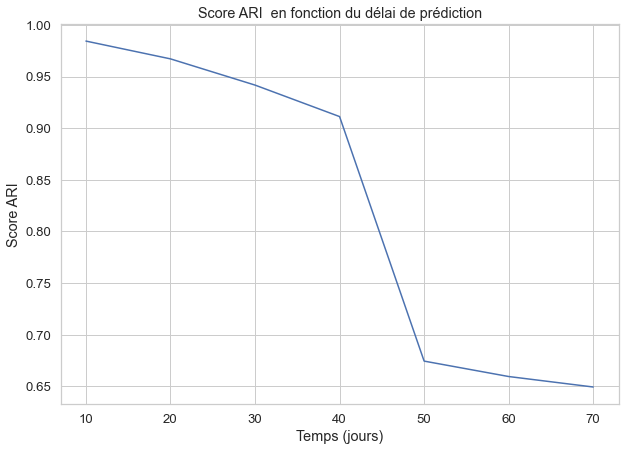

In [66]:
plt.figure(figsize=(10,7))

sns.set(font_scale = 1.2)
sns.set_style("whitegrid") 
sns.lineplot(x="Temps (jours)",y="Score ARI",data=rand,markers=True).set(title="Score ARI  en fonction du délai de prédiction")

D'après les résultats du score ARI, il est conseillé de faire une maintenance du clustering tous les 40 jours environs. 